In [47]:
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt

import volpy_func_lib as vp
import load_clean_lib
import table_lib
import Robustness_Analysis
from mads_testing_stuff import RA_test_env, RA_test_precision_env

from IPython.display import display

In [48]:
importlib.reload(vp)
importlib.reload(load_clean_lib)
importlib.reload(table_lib)
importlib.reload(RA_test_env)

<module 'mads_testing_stuff.RA_test_env' from 'D:\\Professionelt\\Code\\volpy\\mads_testing_stuff\\RA_test_env.py'>

12 -> 2:20 min

50 -> 16:00 min

In [49]:
importlib.reload(vp)
importlib.reload(load_clean_lib)
importlib.reload(table_lib)
importlib.reload(RA_test_env)
importlib.reload(Robustness_Analysis)
importlib.reload(RA_test_precision_env)


od_RA = Robustness_Analysis.create_fake_option_df(1/12)

# parameter dicts you already have:
bs_params =    {'sigma':0.37, 'r':0.056}
mjd_params =   {'sigma':0.35, 'lam':0.4, 'mu_J':-0.09, 'sigma_J':0.18, 'r':0.056}
heston_params = {'kappa': 1.04, 'theta': 0.37**2, 'xi': 0.9, 'rho': -0.7}
svmjd_params = {**mjd_params, **heston_params}
svmjd_params['theta'] = 0.35**2
svmjd_params.pop('sigma', None)

# 1) build your list‐of‐values column…
ln_vt_theta_vals = np.linspace(-3, 3, 13)
od_RA['ln vt/theta'] = od_RA['ticker'].apply(lambda t: [0] if t in ['BS','MJD'] else ln_vt_theta_vals)

# 2) explode it into real rows
od_RA = od_RA.explode('ln vt/theta').reset_index(drop=True)

# 3) coerce to float64
od_RA['ln vt/theta'] = od_RA['ln vt/theta'].astype(float)

# 4) now your v0 vectorized will work
def compute_v0(row):
    if row['ticker'] == 'BS':
        return bs_params['sigma']**2
    elif row['ticker'] == 'MJD':
        return mjd_params['sigma']**2
    elif row['ticker'] == 'Heston':
        return (np.exp(row['ln vt/theta']) * heston_params['theta'])
    elif row['ticker'] == 'SVMJD':
        return (np.exp(row['ln vt/theta']) * svmjd_params['theta'])
    else:
        return np.nan

od_RA['v0'] = od_RA.apply(compute_v0, axis=1)

# fill your DataFrame’s IV column:
od_RA['Price'] = Robustness_Analysis.price_model(
    od_RA['F'].values,
    od_RA['K'].values,
    od_RA['t_TTM'].values,
    od_RA['cp_flag'].values,
    od_RA['ticker'].values,
    od_RA['v0'].values,
    bs_params,
    mjd_params,
    heston_params,
    svmjd_params,
    high_precision = False
)
od_RA['IV'] = vp.add_bid_mid_ask_IV(od_RA, "Price", safer_version=True)

In [50]:
od_RA["date"] = od_RA["v0"]
df_swaps_low = vp.process_od_rdy_parallel(od_RA[od_RA["low"]], vp.replicate_SW_k, n_points=10000)
df_swaps_high = vp.process_od_rdy_parallel(od_RA[od_RA["high"]], vp.replicate_SW_k, n_points=10000)
od_RA.rename(columns={"ticker": "model"}, inplace=True)

# 2) Extract low/high rows and merge
df_low = (
    df_swaps_low
    .drop_duplicates(["ticker", "v0"])
    .loc[:, ["ticker", "v0", "var_swap_rate", "ln vt/theta"]]
    .rename(columns={"var_swap_rate": "low SW"})
)

df_high = (
    df_swaps_high
    .drop_duplicates(["ticker", "v0"])
    .loc[:, ["ticker", "v0", "var_swap_rate"]]
    .rename(columns={"var_swap_rate": "high SW"})
)

df_merged = pd.merge(df_low, df_high, on=["ticker", "v0"], how="outer")
df_merged.set_index(["ticker", "ln vt/theta"], inplace=True)

Processing Groups: 100%|██████████| 28/28 [00:02<00:00, 12.05it/s]


In [51]:
dt = 1/12
A = (1 - np.exp(-svmjd_params['kappa']*dt)) / (svmjd_params['kappa']*dt)

# Compute analytic value per row
def v_t_analytic_value(row):
    model = row["model"]  # ticker is the index
    v0 = row['v0']
    if model == 'BS':
        v_t = bs_params['sigma']**2
        E_v = v_t
        return v_t, E_v
    elif model == 'MJD':
        v_t = mjd_params['sigma']**2
        E_v = v_t + mjd_params['lam'] * (mjd_params['mu_J']**2 + mjd_params['sigma_J']**2)
        return v_t, E_v
    elif model == 'Heston':
        v_t = heston_params['theta'] + A * (v0 - heston_params['theta'])
        E_v = v_t
        return v_t, E_v
    elif model == 'SVMJD':
        v_t = svmjd_params['theta'] + A * (v0 - svmjd_params['theta'])
        E_v = v_t + svmjd_params['lam'] * (svmjd_params['mu_J']**2 + svmjd_params['sigma_J']**2)
        return v_t, E_v
    else:
        return np.nan, np.nan

df_merged.reset_index(inplace=True)
df_merged.rename(columns={"ticker": "model"}, inplace=True)
df_merged.rename(columns={"low SW": "SW"}, inplace=True)

df_merged[['sigma_t^2', 'analytic']] = df_merged.apply(
    v_t_analytic_value,
    axis=1,
    result_type='expand'
)

df_merged['error'] = df_merged['analytic'] - df_merged['SW']
df_merged['error pct'] = df_merged['error'] / df_merged['analytic'] * 100
df_merged['error high'] = df_merged['analytic'] - df_merged['high SW']
df_merged['error pct high'] = df_merged['error high'] / df_merged['analytic'] * 100
df_merged['error jmp'] = -2 * mjd_params['lam'] * (np.exp(mjd_params['mu_J'] + 0.5*mjd_params['sigma_J']**2) - 1 - mjd_params['mu_J'] - 0.5*(mjd_params['mu_J']**2 + mjd_params['sigma_J']**2))
df_merged.loc[df_merged["model"].isin(["BS", "Heston"]), "error jmp"] = 0

cols_to_front = ["model", "ln vt/theta", "sigma_t^2", "analytic", "SW", "error", "error pct", "error jmp"]
remaining_cols = [col for col in df_merged.columns if col not in cols_to_front]
df_merged = df_merged[cols_to_front + remaining_cols]

In [52]:
# k (denser grid)
with pd.option_context('display.max_rows', None, 'display.float_format', '{:.4f}'.format):
    display(df_merged)

,model,ln vt/theta,sigma_t^2,analytic,SW,error,error pct,error jmp,v0,high SW,error high,error pct high
0,BS,0.0000,0.1369,0.1369,0.1369,0.0000,0.0000,0.0000,0.1369,0.1369,0.0000,0.0000
1,Heston,-3.0000,0.0123,0.0123,0.0127,-0.0004,-3.1907,0.0000,0.0068,0.0123,-0.0000,-0.0758
2,Heston,-2.5000,0.0165,0.0165,0.0171,-0.0006,-3.4059,0.0000,0.0112,0.0165,0.0000,0.1422
3,Heston,-2.0000,0.0235,0.0235,0.0242,-0.0007,-3.1000,0.0000,0.0185,0.0234,0.0001,0.2938
4,Heston,-1.5000,0.0350,0.0350,0.0357,-0.0007,-1.9779,0.0000,0.0305,0.0349,0.0001,0.3908
5,Heston,-1.0000,0.0540,0.0540,0.0542,-0.0002,-0.4038,0.0000,0.0504,0.0538,0.0002,0.4405
6,Heston,-0.5000,0.0853,0.0853,0.0847,0.0006,0.6498,0.0000,0.0830,0.0849,0.0004,0.4636
7,Heston,0.0000,0.1369,0.1369,0.1355,0.0014,1.0576,0.0000,0.1369,0.1362,0.0007,0.4820
8,Heston,0.5000,0.2220,0.2220,0.2193,0.0027,1.2246,0.0000,0.2257,0.2208,0.0011,0.5175
9,Heston,1.0000,0.3622,0.3622,0.3578,0.0044,1.2163,0.0000,0.3721,0.3601,0.0021,0.5887


In [53]:
# importlib.reload(Robustness_Analysis)
# Robustness_Analysis.main_table(df_merged)

C:\Users\User\AppData\Local\Temp\ipykernel_1512\1733178331.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = od_RA_[(od_RA["model"] == model) & (od_RA_["low"] == True)].reset_index()
C:\Users\User\AppData\Local\Temp\ipykernel_1512\1733178331.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = od_RA_[(od_RA["model"] == model) & (od_RA_["low"] == True)].reset_index()
C:\Users\User\AppData\Local\Temp\ipykernel_1512\1733178331.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = od_RA_[(od_RA["model"] == model) & (od_RA_["low"] == True)].reset_index()
C:\Users\User\AppData\Local\Temp\ipykernel_1512\1733178331.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = od_RA_[(od_RA["model"] == model) & (od_RA_["low"] == True)].reset_index()


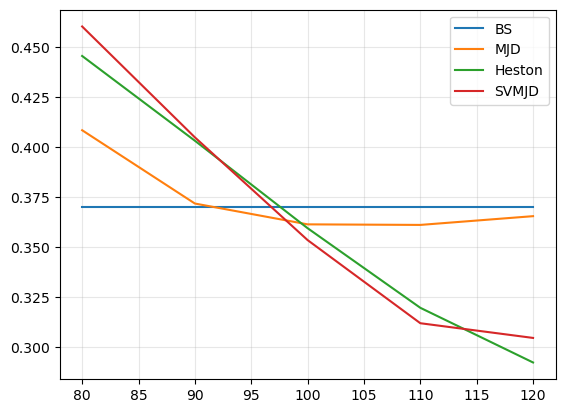

In [54]:
# df_BS = od_RA[(od_RA["ticker"] == "BS") & (od_RA["high"] == True)].reset_index()
# df_MJD = od_RA[(od_RA["ticker"] == "MJD") & (od_RA["low"] == True)].reset_index()
# df_Heston = od_RA[(od_RA["ticker"] == "Heston") & (od_RA["high"] == True)].reset_index()

od_RA_ = od_RA[(od_RA["ln vt/theta"] == 0) | (od_RA["model"].isin(["BS", "MJD"]))]
for model in ["BS", "MJD", "Heston", "SVMJD"]:
    df = od_RA_[(od_RA["model"] == model) & (od_RA_["low"] == True)].reset_index()
    plt.plot(df["K"], df["IV"], label = f"{model}")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

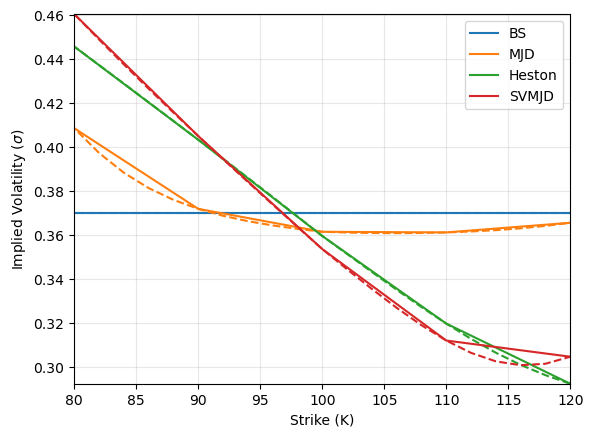

In [128]:
import matplotlib.pyplot as plt

od_RA_ = od_RA[(od_RA["ln vt/theta"] == 0) | (od_RA["model"].isin(["BS", "MJD"]))].copy()
low_df = od_RA_[od_RA_["low"] == True].copy()
high_df = od_RA_[od_RA_["high"] == True].copy()

colors = {}  # store colors to ensure consistency

for model in ["BS", "MJD", "Heston", "SVMJD"]:
    # Filter and plot the "low" line (solid)
    df_low = low_df[low_df["model"] == model].copy()
    line, = plt.plot(df_low["K"], df_low["IV"], label=model)
    colors[model] = line.get_color()  # Save color used for this model

    # Filter and plot the "high" line (dashed)
    df_high = high_df[high_df["model"] == model].copy()
    plt.plot(df_high["K"], df_high["IV"], linestyle="--", color=colors[model])

plt.ylabel(r"Implied Volatility ($\sigma$)")
plt.xlabel("Strike (K)")
plt.grid(alpha=0.3)
plt.legend()
plt.xlim(low_df["K"].min(), low_df["K"].max())
plt.ylim(low_df["IV"].min(), low_df["IV"].max())
plt.savefig("figures/Robustness_analysis_vt_0.pdf")
plt.show()


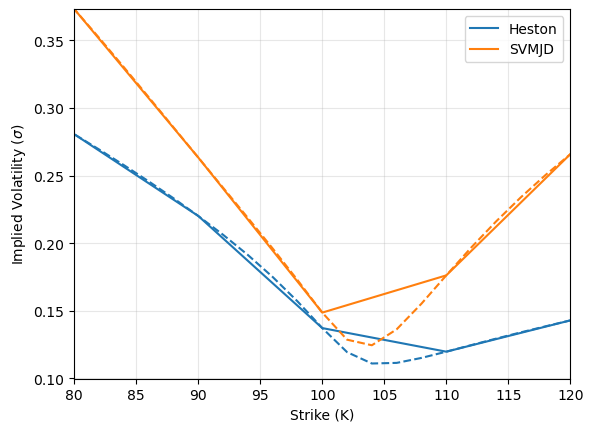

In [129]:
import matplotlib.pyplot as plt

model_list = ["Heston", "SVMJD"]

od_RA_ = od_RA[(od_RA["ln vt/theta"] == -2) | (od_RA["model"].isin(["BS", "MJD"]))].copy()
od_RA_ = od_RA_[od_RA_["model"].isin(model_list)].copy()

low_df = od_RA_[od_RA_["low"] == True].copy()
high_df = od_RA_[od_RA_["high"] == True].copy()

colors = {}  # store colors to ensure consistency

for model in model_list:
    # Filter and plot the "low" line (solid)
    df_low = low_df[low_df["model"] == model].copy()
    line, = plt.plot(df_low["K"], df_low["IV"], label=model)
    colors[model] = line.get_color()  # Save color used for this model

    # Filter and plot the "high" line (dashed)
    df_high = high_df[high_df["model"] == model].copy()
    plt.plot(df_high["K"], df_high["IV"], linestyle="--", color=colors[model])

plt.ylabel(r"Implied Volatility ($\sigma$)")
plt.xlabel("Strike (K)")
plt.grid(alpha=0.3)
plt.legend()
plt.xlim(low_df["K"].min(), low_df["K"].max())
plt.ylim(low_df["IV"].min()-0.02, low_df["IV"].max())
plt.savefig("figures/Robustness_analysis_vt_-2.pdf")
plt.show()


In [153]:
def foo(df, pm_std = 1.5):
    r = df["r"].iloc[0]
    T = df["t_TTM"].iloc[0]  # T in years (e.g. days / 365)
    K_data = df["K"].values
    iv_data = df["IV"].values
    F = df["F"].mean()
    stdev = df["IV"].mean()
    k_min = -pm_std * stdev
    k_max = pm_std * stdev
    k_grid = np.linspace(k_min, k_max, 10000)
    K_grid = F * np.exp(k_grid)
    iv_grid = np.interp(K_grid, K_data, iv_data,
                    left=iv_data[0],
                    right=iv_data[-1])
    is_call = (K_grid > F)  # Boolean array for call/put decision
    # d1 = (np.log(F / K_grid) + (r + 0.5 * iv_grid ** 2) * T) / (iv_grid * np.sqrt(T)) # Not the forward method (r should be removed)
    d1 = (np.log(F / K_grid) + 0.5 * iv_grid ** 2 * T) / (iv_grid * np.sqrt(T))
    d2 = d1 - iv_grid * np.sqrt(T)
    call_prices = np.exp(-r * T) * (F * norm.cdf(d1) - K_grid * norm.cdf(d2))
    put_prices = call_prices - np.exp(-r * T) * (F - K_grid)
    option_prices = np.where(is_call, call_prices, put_prices)

    # The OTM option price from BSM_call_put is discounted, so multiply by e^{rT}.
    undiscounted_option_prices = option_prices * np.exp(r * T)
    integrand = undiscounted_option_prices * 2/K_grid**2
    
    return K_grid, iv_grid, undiscounted_option_prices, integrand

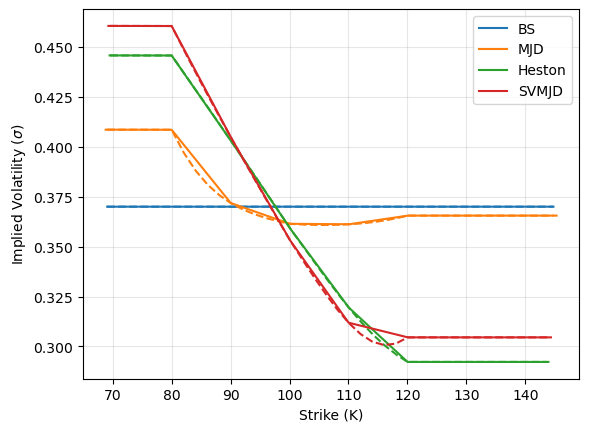

In [130]:
import matplotlib.pyplot as plt
from scipy.stats import norm

od_RA_ = od_RA[(od_RA["ln vt/theta"] == 0) | (od_RA["model"].isin(["BS", "MJD"]))].copy()
low_df = od_RA_[od_RA_["low"] == True].copy()
high_df = od_RA_[od_RA_["high"] == True].copy()

colors = {}  # store colors to ensure consistency

for model in ["BS", "MJD", "Heston", "SVMJD"]:
    # Filter and plot the "low" line (solid)
    df_low = low_df[low_df["model"] == model].copy()
    K_grid, iv_grid, undiscounted_option_prices = foo(df_low, pm_std=1)

    line, = plt.plot(K_grid, iv_grid, label=model)
    
    
    # Filter and plot the "high" line (dashed)
    df_high = high_df[high_df["model"] == model].copy()
    df_high = df_high[(df_high["K"] >= df_low["K"].min()) & (df_high["K"] <= df_low["K"].max())].copy()
    K_grid, iv_grid, undiscounted_option_prices = foo(df_high, pm_std=1)

    colors[model] = line.get_color()  # Save color used for this model
    plt.plot(K_grid, iv_grid, linestyle="--", color=colors[model])

plt.ylabel(r"Implied Volatility ($\sigma$)")
plt.xlabel("Strike (K)")
plt.grid(alpha=0.3)
plt.legend()
# plt.xlim(low_df["K"].min(), low_df["K"].max())
# plt.ylim(low_df["IV"].min(), low_df["IV"].max())
plt.savefig("figures/Robustness_analysis_vt_0_integration.pdf")
plt.show()

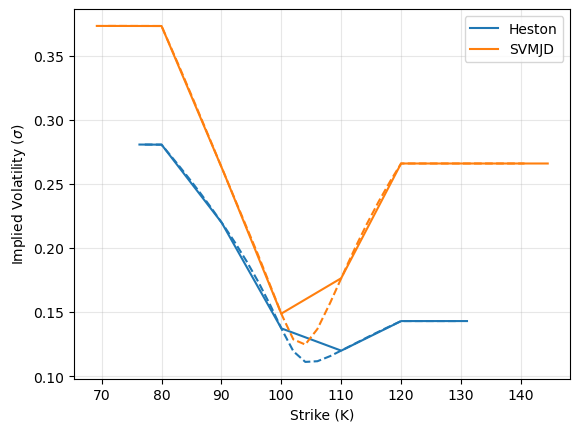

In [131]:
import matplotlib.pyplot as plt
from scipy.stats import norm

model_list = ["Heston", "SVMJD"]

od_RA_ = od_RA[(od_RA["ln vt/theta"] == -2) | (od_RA["model"].isin(["BS", "MJD"]))].copy()
od_RA_ = od_RA_[od_RA_["model"].isin(model_list)].copy()

low_df = od_RA_[od_RA_["low"] == True].copy()
high_df = od_RA_[od_RA_["high"] == True].copy()

colors = {}  # store colors to ensure consistency

for model in model_list:
    # Filter and plot the "low" line (solid)
    df_low = low_df[low_df["model"] == model].copy()
    K_grid, iv_grid, undiscounted_option_prices = foo(df_low, pm_std=1.5)

    line, = plt.plot(K_grid, iv_grid, label=model)
    
    
    # Filter and plot the "high" line (dashed)
    df_high = high_df[high_df["model"] == model].copy()
    df_high = df_high[(df_high["K"] >= df_low["K"].min()) & (df_high["K"] <= df_low["K"].max())].copy()
    K_grid, iv_grid, undiscounted_option_prices = foo(df_high, pm_std=1.5)

    colors[model] = line.get_color()  # Save color used for this model
    plt.plot(K_grid, iv_grid, linestyle="--", color=colors[model])

plt.ylabel(r"Implied Volatility ($\sigma$)")
plt.xlabel("Strike (K)")
plt.grid(alpha=0.3)
plt.legend()
# plt.xlim(low_df["K"].min(), low_df["K"].max())
# plt.ylim(low_df["IV"].min(), low_df["IV"].max())
plt.savefig("figures/Robustness_analysis_vt_0_integration.pdf")
plt.show()


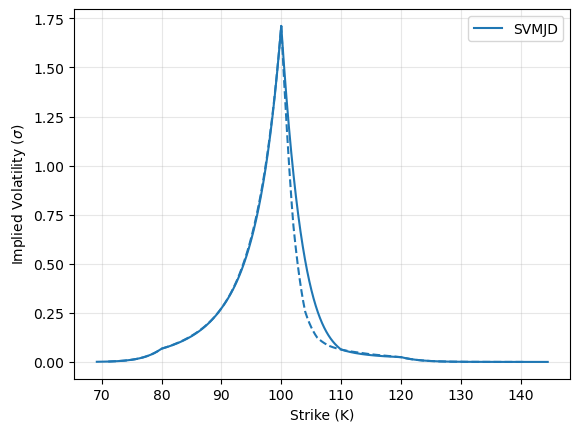

In [133]:
import matplotlib.pyplot as plt
from scipy.stats import norm

model_list = ["SVMJD"]

od_RA_ = od_RA[(od_RA["ln vt/theta"] == -2) | (od_RA["model"].isin(["BS", "MJD"]))].copy()
od_RA_ = od_RA_[od_RA_["model"].isin(model_list)].copy()

low_df = od_RA_[od_RA_["low"] == True].copy()
high_df = od_RA_[od_RA_["high"] == True].copy()

colors = {}  # store colors to ensure consistency

for model in model_list:
    # Filter and plot the "low" line (solid)
    df_low = low_df[low_df["model"] == model].copy()
    K_grid, iv_grid, undiscounted_option_prices = foo(df_low, pm_std=1.5)

    line, = plt.plot(K_grid, undiscounted_option_prices, label=model)
    
    
    # Filter and plot the "high" line (dashed)
    df_high = high_df[high_df["model"] == model].copy()
    df_high = df_high[(df_high["K"] >= df_low["K"].min()) & (df_high["K"] <= df_low["K"].max())].copy()
    K_grid, iv_grid, undiscounted_option_prices = foo(df_high, pm_std=1.5)

    colors[model] = line.get_color()  # Save color used for this model
    plt.plot(K_grid, undiscounted_option_prices, linestyle="--", color=colors[model])

plt.ylabel(r"Implied Volatility ($\sigma$)")
plt.xlabel("Strike (K)")
plt.grid(alpha=0.3)
plt.legend()
# plt.xlim(low_df["K"].min(), low_df["K"].max())
# plt.ylim(low_df["IV"].min(), low_df["IV"].max())
plt.savefig("figures/Robustness_analysis_vt_0_integration_price.pdf")
plt.show()


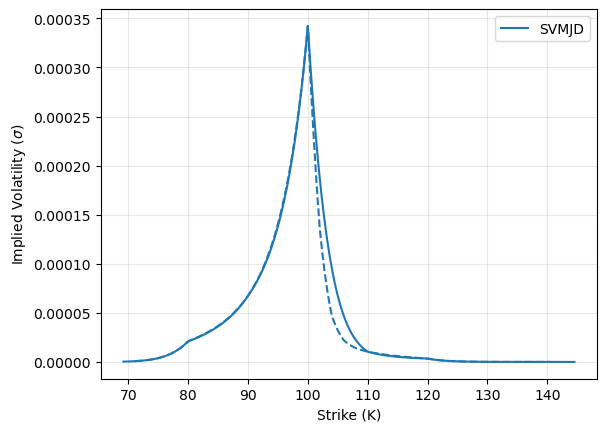

In [136]:
import matplotlib.pyplot as plt
from scipy.stats import norm

model_list = ["SVMJD"]

od_RA_ = od_RA[(od_RA["ln vt/theta"] == -2) | (od_RA["model"].isin(["BS", "MJD"]))].copy()
od_RA_ = od_RA_[od_RA_["model"].isin(model_list)].copy()

low_df = od_RA_[od_RA_["low"] == True].copy()
high_df = od_RA_[od_RA_["high"] == True].copy()

colors = {}  # store colors to ensure consistency

for model in model_list:
    # Filter and plot the "low" line (solid)
    df_low = low_df[low_df["model"] == model].copy()
    K_grid, iv_grid, undiscounted_option_prices = foo(df_low, pm_std=1.5)

    line, = plt.plot(K_grid, undiscounted_option_prices * 2/K_grid**2, label=model)
    
    
    # Filter and plot the "high" line (dashed)
    df_high = high_df[high_df["model"] == model].copy()
    df_high = df_high[(df_high["K"] >= df_low["K"].min()) & (df_high["K"] <= df_low["K"].max())].copy()
    K_grid, iv_grid, undiscounted_option_prices = foo(df_high, pm_std=1.5)

    colors[model] = line.get_color()  # Save color used for this model
    plt.plot(K_grid, undiscounted_option_prices * 2/(K_grid**2), linestyle="--", color=colors[model])

plt.ylabel(r"Implied Volatility ($\sigma$)")
plt.xlabel("Strike (K)")
plt.grid(alpha=0.3)
plt.legend()
# plt.xlim(low_df["K"].min(), low_df["K"].max())
# plt.ylim(low_df["IV"].min(), low_df["IV"].max())
plt.savefig("figures/Robustness_analysis_vt_0_integration_price.pdf")
plt.show()

# Start here

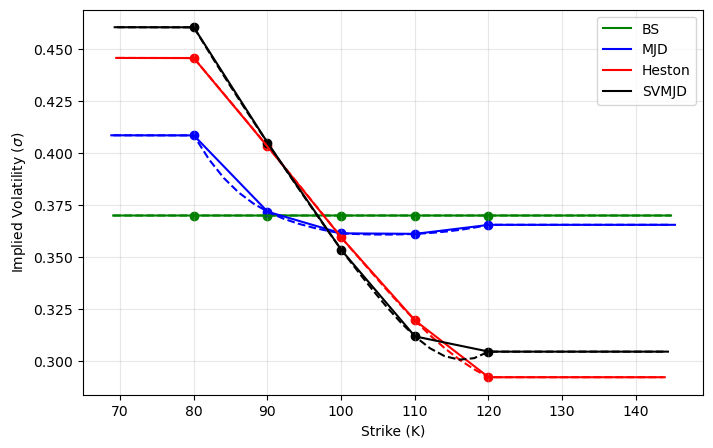

In [232]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
model_list = ["BS", "MJD", "Heston", "SVMJD"]
color_list = ["green", "blue", "red", "black"]
vt = 0
pm_std = 1

od_RA_ = od_RA[(od_RA["ln vt/theta"] == vt) | (od_RA["model"].isin(["BS", "MJD"]))].copy()
od_RA_ = od_RA_[od_RA_["model"].isin(model_list)].copy()
low_df = od_RA_[od_RA_["low"] == True].copy()
high_df = od_RA_[od_RA_["high"] == True].copy()

colors = {}  # store colors to ensure consistency

for model, color in zip(model_list, color_list):
        
    # Filter and plot the "low" line (solid)
    df_low = low_df[low_df["model"] == model].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_low, pm_std=pm_std)
    
    plt.scatter(df_low["K"], df_low["IV"], color = color)
    line, = plt.plot(K_grid, iv_grid, label=f"{model}", color = color)
    colors[model] = line.get_color()  # Save color used for this model

    # Filter and plot the "high" line (dashed)
    df_high = high_df[high_df["model"] == model].copy()
    df_high = df_high[(df_high["K"] >= df_low["K"].min()) & (df_high["K"] <= df_low["K"].max())].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_high, pm_std=pm_std)
    
    colors[model] = line.get_color()  # Save color used for this model

    plt.plot(K_grid, iv_grid, linestyle="--", color=colors[model])

plt.ylabel(r"Implied Volatility ($\sigma$)")
plt.xlabel("Strike (K)")
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("figures/Robustness_analysis_IV_vt0_all_models.pdf")
plt.show()

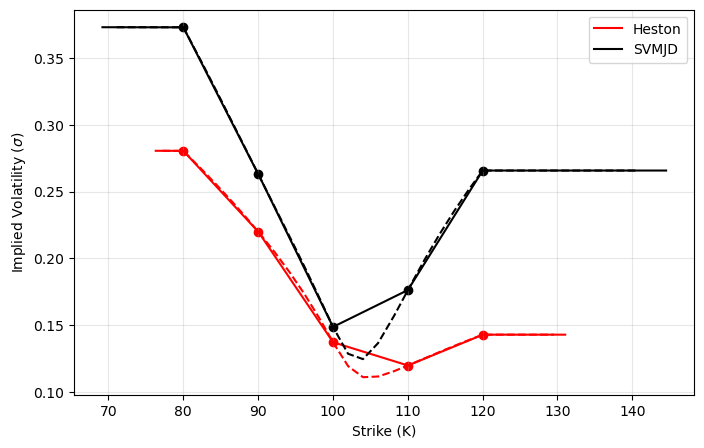

In [233]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
model_list = ["Heston", "SVMJD"]
color_list = ["red", "black"]
vt = -2
pm_std = 1.5

od_RA_ = od_RA[(od_RA["ln vt/theta"] == vt) | (od_RA["model"].isin(["BS", "MJD"]))].copy()
od_RA_ = od_RA_[od_RA_["model"].isin(model_list)].copy()
low_df = od_RA_[od_RA_["low"] == True].copy()
high_df = od_RA_[od_RA_["high"] == True].copy()

colors = {}  # store colors to ensure consistency

for model, color in zip(model_list, color_list):
        
    # Filter and plot the "low" line (solid)
    df_low = low_df[low_df["model"] == model].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_low, pm_std=pm_std)
    
    plt.scatter(df_low["K"], df_low["IV"], color = color)
    line, = plt.plot(K_grid, iv_grid, label=f"{model}", color = color)
    colors[model] = line.get_color()  # Save color used for this model

    # Filter and plot the "high" line (dashed)
    df_high = high_df[high_df["model"] == model].copy()
    df_high = df_high[(df_high["K"] >= df_low["K"].min()) & (df_high["K"] <= df_low["K"].max())].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_high, pm_std=pm_std)
    
    colors[model] = line.get_color()  # Save color used for this model

    plt.plot(K_grid, iv_grid, linestyle="--", color=colors[model])

plt.ylabel(r"Implied Volatility ($\sigma$)")
plt.xlabel("Strike (K)")
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("figures/Robustness_analysis_IV_vt-2_SV_models.pdf")
plt.show()

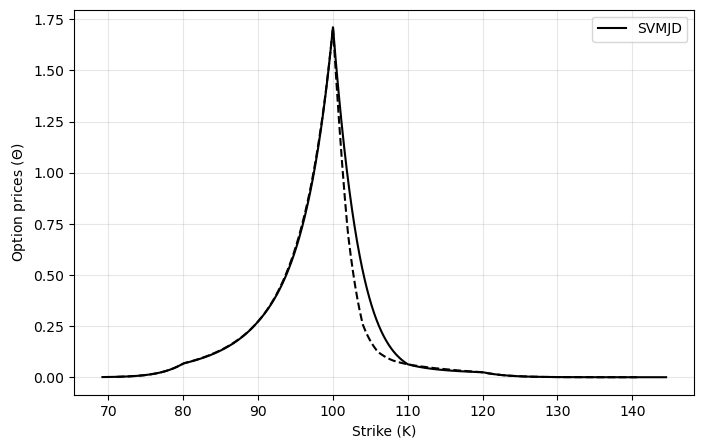

In [234]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
model_list = ["SVMJD"]
color_list = ["black"]
vt = -2
pm_std = 1.5

od_RA_ = od_RA[(od_RA["ln vt/theta"] == vt) | (od_RA["model"].isin(["BS", "MJD"]))].copy()
od_RA_ = od_RA_[od_RA_["model"].isin(model_list)].copy()
low_df = od_RA_[od_RA_["low"] == True].copy()
high_df = od_RA_[od_RA_["high"] == True].copy()

colors = {}  # store colors to ensure consistency

for model, color in zip(model_list, color_list):
        
    # Filter and plot the "low" line (solid)
    df_low = low_df[low_df["model"] == model].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_low, pm_std=pm_std)
    
    line, = plt.plot(K_grid, undiscounted_option_prices, label=f"{model}", color = color)
    colors[model] = line.get_color()  # Save color used for this model

    # Filter and plot the "high" line (dashed)
    df_high = high_df[high_df["model"] == model].copy()
    df_high = df_high[(df_high["K"] >= df_low["K"].min()) & (df_high["K"] <= df_low["K"].max())].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_high, pm_std=pm_std)
    
    colors[model] = line.get_color()  # Save color used for this model

    plt.plot(K_grid, undiscounted_option_prices, linestyle="--", color=colors[model])

plt.ylabel(r"Option prices ($\Theta$)")
plt.xlabel("Strike (K)")
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("figures/Robustness_analysis_price_vt-2_SVMJD.pdf")
plt.show()

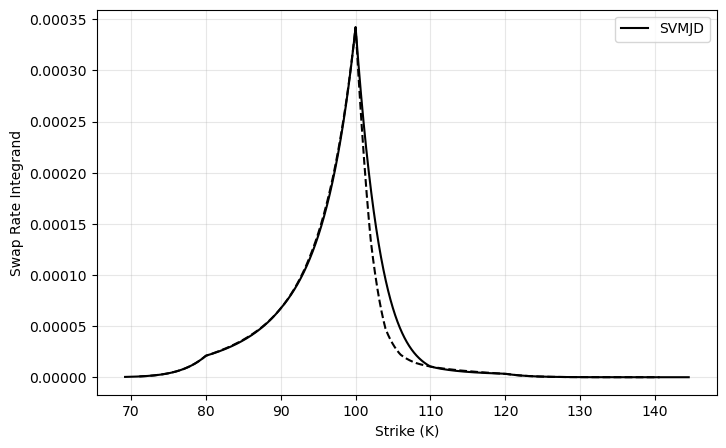

In [235]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
model_list = ["SVMJD"]
color_list = ["black"]
vt = -2
pm_std = 1.5

od_RA_ = od_RA[(od_RA["ln vt/theta"] == vt) | (od_RA["model"].isin(["BS", "MJD"]))].copy()
od_RA_ = od_RA_[od_RA_["model"].isin(model_list)].copy()
low_df = od_RA_[od_RA_["low"] == True].copy()
high_df = od_RA_[od_RA_["high"] == True].copy()

colors = {}  # store colors to ensure consistency

for model, color in zip(model_list, color_list):
        
    # Filter and plot the "low" line (solid)
    df_low = low_df[low_df["model"] == model].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_low, pm_std=pm_std)
    
    line, = plt.plot(K_grid, integrand, label=f"{model}", color = color)
    colors[model] = line.get_color()  # Save color used for this model

    # Filter and plot the "high" line (dashed)
    df_high = high_df[high_df["model"] == model].copy()
    df_high = df_high[(df_high["K"] >= df_low["K"].min()) & (df_high["K"] <= df_low["K"].max())].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_high, pm_std=pm_std)
    
    colors[model] = line.get_color()  # Save color used for this model

    plt.plot(K_grid, integrand, linestyle="--", color=colors[model])

plt.ylabel(r"Swap Rate Integrand")
plt.xlabel("Strike (K)")
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("figures/Robustness_analysis_integrand_vt-2_SVMJD.pdf")
plt.show()

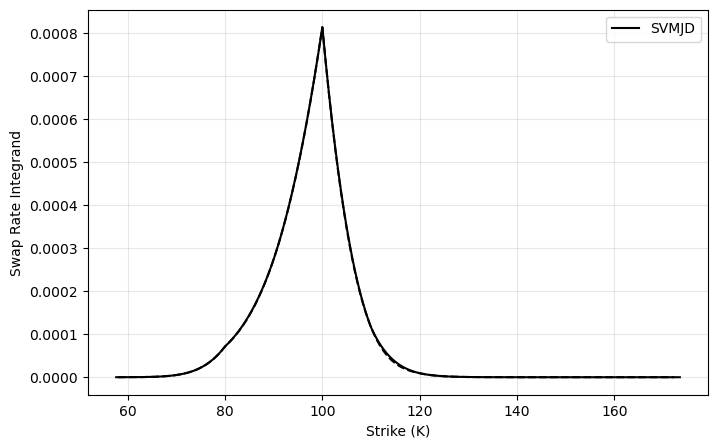

In [236]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
model_list = ["SVMJD"]
color_list = ["black"]
vt = 0
pm_std = 1.5

od_RA_ = od_RA[(od_RA["ln vt/theta"] == vt) | (od_RA["model"].isin(["BS", "MJD"]))].copy()
od_RA_ = od_RA_[od_RA_["model"].isin(model_list)].copy()
low_df = od_RA_[od_RA_["low"] == True].copy()
high_df = od_RA_[od_RA_["high"] == True].copy()

colors = {}  # store colors to ensure consistency

for model, color in zip(model_list, color_list):
        
    # Filter and plot the "low" line (solid)
    df_low = low_df[low_df["model"] == model].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_low, pm_std=pm_std)
    
    line, = plt.plot(K_grid, integrand, label=f"{model}", color = color)
    colors[model] = line.get_color()  # Save color used for this model

    # Filter and plot the "high" line (dashed)
    df_high = high_df[high_df["model"] == model].copy()
    df_high = df_high[(df_high["K"] >= df_low["K"].min()) & (df_high["K"] <= df_low["K"].max())].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_high, pm_std=pm_std)
    
    colors[model] = line.get_color()  # Save color used for this model

    plt.plot(K_grid, integrand, linestyle="--", color=colors[model])

plt.ylabel(r"Swap Rate Integrand")
plt.xlabel("Strike (K)")
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("figures/Robustness_analysis_integrand_vt0_SVMJD.pdf")
plt.show()

# End

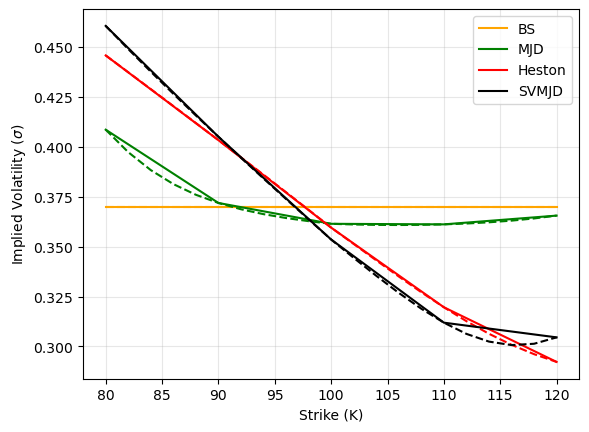

In [231]:
import matplotlib.pyplot as plt

model_list = ["BS", "MJD", "Heston", "SVMJD"]
color_list = ["orange", "green", "red", "black"]
vt = 0
pm_std = 1.5

od_RA_ = od_RA[(od_RA["ln vt/theta"] == vt) | (od_RA["model"].isin(["BS", "MJD"]))].copy()
od_RA_ = od_RA_[od_RA_["model"].isin(model_list)].copy()
low_df = od_RA_[od_RA_["low"] == True].copy()
high_df = od_RA_[od_RA_["high"] == True].copy()

colors = {}  # store colors to ensure consistency

for model, color in zip(model_list, color_list):
    
    # if model == "SVMJD":
    #     alpha = 1
    #     lw = 1.5
    # else:
    #     alpha = 0.5
    #     lw = 1
    
    # Filter and plot the "low" line (solid)
    df_low = low_df[low_df["model"] == model].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_low, pm_std=pm_std)
    
    line, = plt.plot(df_low["K"], df_low["IV"], label=model, color = color)
    colors[model] = line.get_color()  # Save color used for this model

    # Filter and plot the "high" line (dashed)
    df_high = high_df[high_df["model"] == model].copy()
    df_high = df_high[(df_high["K"] >= df_low["K"].min()) & (df_high["K"] <= df_low["K"].max())].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_high, pm_std=pm_std)
    
    colors[model] = line.get_color()  # Save color used for this model

    plt.plot(df_high["K"], df_high["IV"], linestyle="--", color=colors[model])

plt.ylabel(r"Implied Volatility ($\sigma$)")
plt.xlabel("Strike (K)")
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("figures/Robustness_analysis_vt_0.pdf")
plt.show()

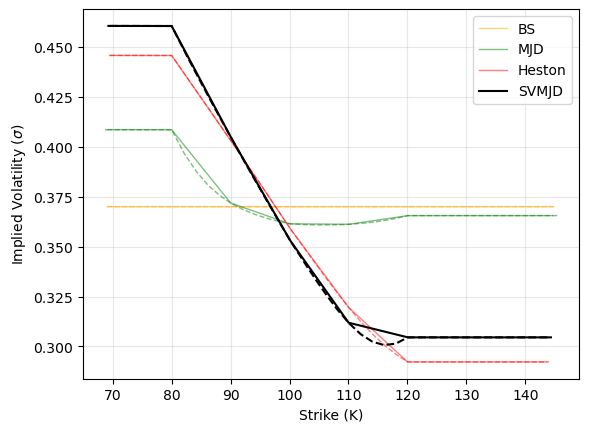

In [198]:
import matplotlib.pyplot as plt

model_list = ["BS", "MJD", "Heston", "SVMJD"]
color_list = ["orange", "green", "red", "black"]
vt = 0
pm_std = 1

od_RA_ = od_RA[(od_RA["ln vt/theta"] == vt) | (od_RA["model"].isin(["BS", "MJD"]))].copy()
od_RA_ = od_RA_[od_RA_["model"].isin(model_list)].copy()
low_df = od_RA_[od_RA_["low"] == True].copy()
high_df = od_RA_[od_RA_["high"] == True].copy()

colors = {}  # store colors to ensure consistency

for model, color in zip(model_list, color_list):
    
    if model == "SVMJD":
        alpha = 1
        lw = 1.5
    else:
        alpha = 0.5
        lw = 1
    
    # Filter and plot the "low" line (solid)
    df_low = low_df[low_df["model"] == model].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_low, pm_std=pm_std)
    
    line, = plt.plot(K_grid, iv_grid, label=model, alpha = alpha, lw = lw, color = color)
    colors[model] = line.get_color()  # Save color used for this model

    # Filter and plot the "high" line (dashed)
    df_high = high_df[high_df["model"] == model].copy()
    df_high = df_high[(df_high["K"] >= df_low["K"].min()) & (df_high["K"] <= df_low["K"].max())].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_high, pm_std=pm_std)
    
    colors[model] = line.get_color()  # Save color used for this model

    plt.plot(K_grid, iv_grid, linestyle="--", color=colors[model], alpha = alpha, lw = lw)

plt.ylabel(r"Implied Volatility ($\sigma$)")
plt.xlabel("Strike (K)")
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("figures/Robustness_analysis_vt_0.pdf")
plt.show()

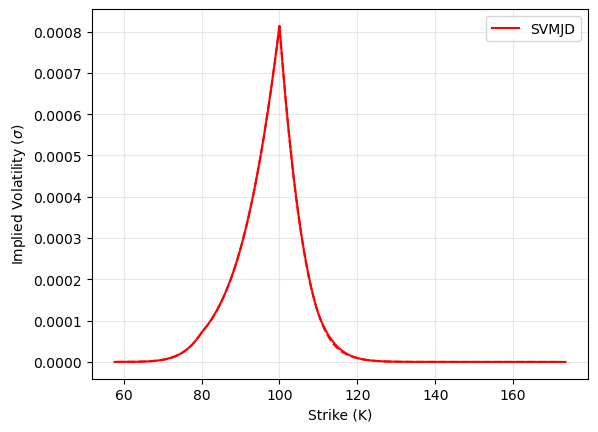

In [179]:
import matplotlib.pyplot as plt

model_list = ["SVMJD"]
color_list = ["red"]
vt = 0
pm_std = 1.5

od_RA_ = od_RA[(od_RA["ln vt/theta"] == vt) | (od_RA["model"].isin(["BS", "MJD"]))].copy()
od_RA_ = od_RA_[od_RA_["model"].isin(model_list)].copy()
low_df = od_RA_[od_RA_["low"] == True].copy()
high_df = od_RA_[od_RA_["high"] == True].copy()

colors = {}  # store colors to ensure consistency

for model, color in zip(model_list, color_list):
    
    if model == "SVMJD":
        alpha = 1
        lw = 1.5
    else:
        alpha = 0.5
        lw = 1.0
    
    # Filter and plot the "low" line (solid)
    df_low = low_df[low_df["model"] == model].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_low, pm_std=pm_std)
    
    line, = plt.plot(K_grid, integrand, label=model, alpha = alpha, lw = lw, color = color)
    colors[model] = line.get_color()  # Save color used for this model

    # Filter and plot the "high" line (dashed)
    df_high = high_df[high_df["model"] == model].copy()
    df_high = df_high[(df_high["K"] >= df_low["K"].min()) & (df_high["K"] <= df_low["K"].max())].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_high, pm_std=pm_std)
    
    colors[model] = line.get_color()  # Save color used for this model

    plt.plot(K_grid, integrand, linestyle="--", color=colors[model], alpha = alpha, lw = lw)

plt.ylabel(r"Implied Volatility ($\sigma$)")
plt.xlabel("Strike (K)")
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("figures/Robustness_analysis_vt_0.pdf")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

model_list = ["BS", "MJD", "Heston", "SVMJD"]
vt = -2

od_RA_ = od_RA[(od_RA["ln vt/theta"] == vt) | (od_RA["model"].isin(["BS", "MJD"]))].copy()
od_RA_ = od_RA_[od_RA_["model"].isin(model_list)].copy()
low_df = od_RA_[od_RA_["low"] == True].copy()
high_df = od_RA_[od_RA_["high"] == True].copy()

colors = {}  # store colors to ensure consistency

for model in model_list:
    
    if model == "SVMJD":
        alpha = 1
        lw = 1.5
    else:
        alpha = 0.3
        lw = 1
    
    # Filter and plot the "low" line (solid)
    df_low = low_df[low_df["model"] == model].copy()
    line, = plt.plot(df_low["K"], df_low["IV"], label=model, alpha = alpha, lw = lw)
    colors[model] = line.get_color()  # Save color used for this model

    # Filter and plot the "high" line (dashed)
    df_high = high_df[high_df["model"] == model].copy()
    colors[model] = line.get_color()  # Save color used for this model

    plt.plot(df_high["K"], df_high["IV"], linestyle="--", color=colors[model], alpha = alpha, lw = lw)

plt.ylabel(r"Implied Volatility ($\sigma$)")
plt.xlabel("Strike (K)")
plt.grid(alpha=0.3)
plt.legend()
plt.xlim(low_df["K"].min(), low_df["K"].max())
plt.ylim(low_df["IV"].min()-0.02, low_df["IV"].max())
plt.savefig("figures/Robustness_analysis_vt_0.pdf")
plt.show()

In [97]:
df_low["K"].min()

80

In [98]:
df_low["K"].max()

120

In [96]:
(df_high["K"] >= df_low["K"].min()) & df_high["K"] <= df_low["K"].max()

776     True
789     True
802     True
815     True
828     True
841     True
854     True
867     True
880     True
893     True
906     True
919     True
932     True
945     True
958     True
971     True
984     True
997     True
1010    True
1023    True
1036    True
1049    True
1062    True
1075    True
1088    True
1101    True
1114    True
1127    True
1140    True
1153    True
1166    True
1179    True
1192    True
1205    True
1218    True
1231    True
1244    True
1257    True
1270    True
1283    True
1296    True
1309    True
Name: K, dtype: bool

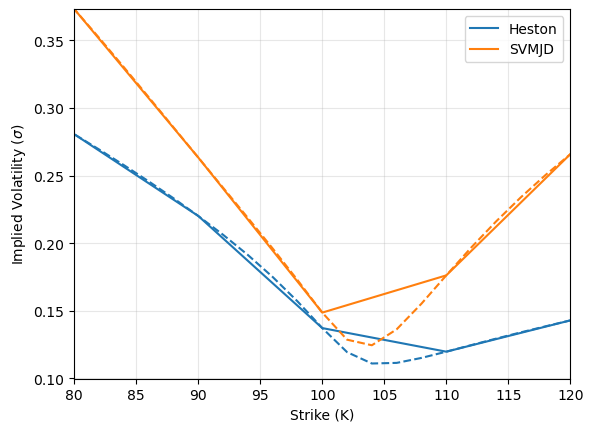

In [69]:
import matplotlib.pyplot as plt

od_RA_ = od_RA[od_RA["model"].isin(["Heston", "SVMJD"])]
od_RA_ = od_RA_[(od_RA_["ln vt/theta"] == -2) | (od_RA_["model"].isin(["BS", "MJD"]))].copy()
low_df = od_RA_[od_RA_["low"] == True].copy()
high_df = od_RA_[od_RA_["high"] == True].copy()

colors = {}  # store colors to ensure consistency

for model in ["Heston", "SVMJD"]:
    # Filter and plot the "low" line (solid)
    df_low = low_df[low_df["model"] == model].copy()
    line, = plt.plot(df_low["K"], df_low["IV"], label=model)
    colors[model] = line.get_color()  # Save color used for this model

    # Filter and plot the "high" line (dashed)
    df_high = high_df[high_df["model"] == model].copy()
    plt.plot(df_high["K"], df_high["IV"], linestyle="--", color=colors[model])

plt.ylabel(r"Implied Volatility ($\sigma$)")
plt.xlabel("Strike (K)")
plt.grid(alpha=0.3)
plt.legend()
plt.xlim(low_df["K"].min(), low_df["K"].max())
plt.ylim(low_df["IV"].min()-0.02, low_df["IV"].max())
plt.savefig("figures/Robustness_analysis_vt_-2.pdf")
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_600\2797404264.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = od_RA_[(od_RA["model"] == model) & (od_RA_["low"] == True)].reset_index()
C:\Users\User\AppData\Local\Temp\ipykernel_600\2797404264.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = od_RA_[(od_RA["model"] == model) & (od_RA_["low"] == True)].reset_index()
C:\Users\User\AppData\Local\Temp\ipykernel_600\2797404264.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = od_RA_[(od_RA["model"] == model) & (od_RA_["low"] == True)].reset_index()
C:\Users\User\AppData\Local\Temp\ipykernel_600\2797404264.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = od_RA_[(od_RA["model"] == model) & (od_RA_["low"] == True)].reset_index()


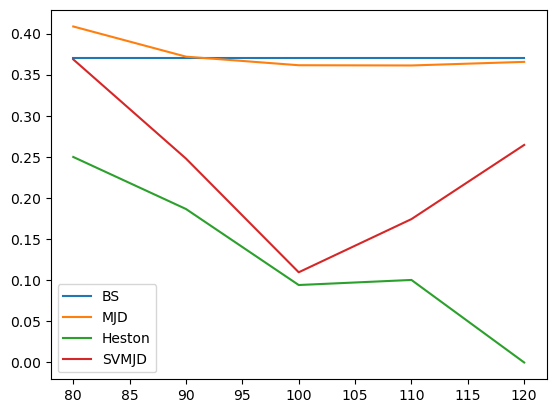

In [166]:
# df_BS = od_RA[(od_RA["ticker"] == "BS") & (od_RA["high"] == True)].reset_index()
# df_MJD = od_RA[(od_RA["ticker"] == "MJD") & (od_RA["low"] == True)].reset_index()
# df_Heston = od_RA[(od_RA["ticker"] == "Heston") & (od_RA["high"] == True)].reset_index()

od_RA_ = od_RA[(od_RA["ln vt/theta"] == -3) | (od_RA["model"].isin(["BS", "MJD"]))]
for model in ["BS", "MJD", "Heston", "SVMJD"]:
    df = od_RA_[(od_RA["model"] == model) & (od_RA_["low"] == True)].reset_index()
    plt.plot(df["K"], df["IV"], label = f"{model}")
plt.legend()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_600\3173387557.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = od_RA_[(od_RA["model"] == model) & (od_RA_["high"] == True)].reset_index()
C:\Users\User\AppData\Local\Temp\ipykernel_600\3173387557.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = od_RA_[(od_RA["model"] == model) & (od_RA_["high"] == True)].reset_index()
C:\Users\User\AppData\Local\Temp\ipykernel_600\3173387557.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = od_RA_[(od_RA["model"] == model) & (od_RA_["high"] == True)].reset_index()
C:\Users\User\AppData\Local\Temp\ipykernel_600\3173387557.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = od_RA_[(od_RA["model"] == model) & (od_RA_["high"] == True)].reset_index()


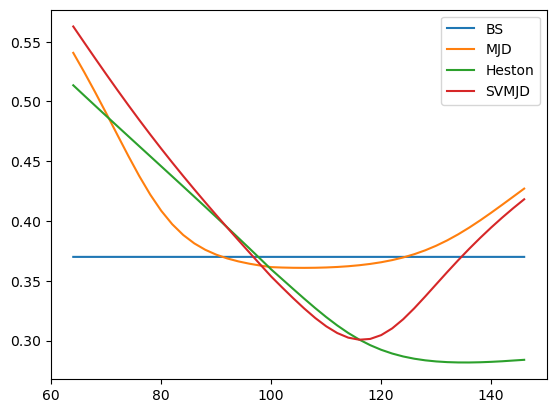

In [163]:
# df_BS = od_RA[(od_RA["ticker"] == "BS") & (od_RA["high"] == True)].reset_index()
# df_MJD = od_RA[(od_RA["ticker"] == "MJD") & (od_RA["low"] == True)].reset_index()
# df_Heston = od_RA[(od_RA["ticker"] == "Heston") & (od_RA["high"] == True)].reset_index()

od_RA_ = od_RA[(od_RA["ln vt/theta"] == 0) | (od_RA["model"].isin(["BS", "MJD"]))]
for model in ["BS", "MJD", "Heston", "SVMJD"]:
    df = od_RA_[(od_RA["model"] == model) & (od_RA_["high"] == True)].reset_index()
    plt.plot(df["K"], df["IV"], label = f"{model}")
plt.legend()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_600\4162295277.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = od_RA_[(od_RA["model"] == model) & (od_RA_["low"] == True)].reset_index()
C:\Users\User\AppData\Local\Temp\ipykernel_600\4162295277.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = od_RA_[(od_RA["model"] == model) & (od_RA_["low"] == True)].reset_index()
C:\Users\User\AppData\Local\Temp\ipykernel_600\4162295277.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = od_RA_[(od_RA["model"] == model) & (od_RA_["low"] == True)].reset_index()
C:\Users\User\AppData\Local\Temp\ipykernel_600\4162295277.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = od_RA_[(od_RA["model"] == model) & (od_RA_["low"] == True)].reset_index()
C:\Users\User\AppData\Local\Temp\ipykernel_600\4162295277.py:9: UserWarning: Boolean Series key will be reindexed to

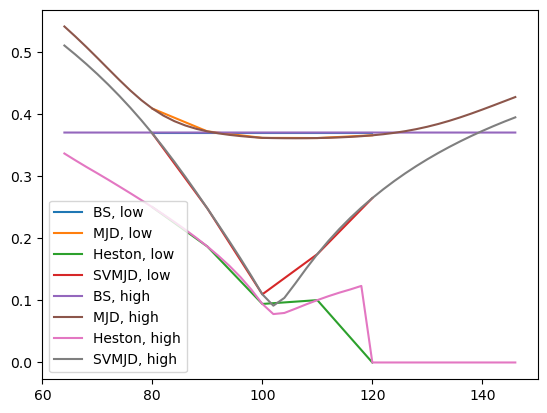

In [165]:
od_RA_ = od_RA[(od_RA["ln vt/theta"] == -3) | (od_RA["model"].isin(["BS", "MJD"]))]


for model in ["BS", "MJD", "Heston", "SVMJD"]:
    df = od_RA_[(od_RA["model"] == model) & (od_RA_["low"] == True)].reset_index()
    plt.plot(df["K"], df["IV"], label = f"{model}, low")

for model in ["BS", "MJD", "Heston", "SVMJD"]:
    df = od_RA_[(od_RA["model"] == model) & (od_RA_["high"] == True)].reset_index()
    plt.plot(df["K"], df["IV"], label=f"{model}, high")
plt.legend()
plt.show()



In [64]:
od_RA['Price'].min()

-4.5733016648592036e-07

In [62]:
od_RA

,model,cp_flag,K,t_days,t_TTM,r,F,IV,low,high,ln vt/theta,v0,Price,date
0,BS,P,80.000000,21,0.083333,0.056,100,0.370000,True,False,0.0,0.136900,0.063596,0.136900
1,BS,P,90.000000,21,0.083333,0.056,100,0.370000,True,False,0.0,0.136900,0.865485,0.136900
2,BS,P,99.999999,21,0.083333,0.056,100,0.370000,True,False,0.0,0.136900,4.259069,0.136900
3,BS,C,100.000001,21,0.083333,0.056,100,0.370000,True,False,0.0,0.136900,4.259069,0.136900
4,BS,C,110.000000,21,0.083333,0.056,100,0.370000,True,False,0.0,0.136900,1.139957,0.136900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2683,SVMJD,C,149.000000,21,0.083333,0.056,100,0.495243,False,True,1.0,0.332990,0.013735,0.332990
2684,SVMJD,C,149.000000,21,0.083333,0.056,100,0.646605,False,True,1.5,0.549007,0.132749,0.549007
2685,SVMJD,C,149.000000,21,0.083333,0.056,100,0.864399,False,True,2.0,0.905159,0.707031,0.905159
2686,SVMJD,C,149.000000,21,0.083333,0.056,100,1.139687,False,True,2.5,1.492356,2.177755,1.492356
